# Natural Language Processing and Swedish Mutual Funds

#### We will be using NLP on a collection of short descriptions of 1320 mutual funds. The primary NLP packages we will playing with is NLTK. The fund descriptions are in swedish, and NLTK does have some support for the swedish language.

#### First, we import some packages we'll be using and open the fund dictionary (i.e. hash table), which is currently stored in json format.

In [117]:
import nltk
from nltk.text import Text
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem.snowball import SwedishStemmer
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.metrics import pairwise_distances
from PIL import Image
import json
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

with open('dict_of_funds.json', 'r') as g:
     dict_of_funds = json.load(g)

In [45]:
len(dict_of_funds)

1320

#### There are 1320 funds and below is an example of the information available for a given fund. We will primarily be interested in a short 1-4 sentence summary ofthe fund, whichis stored under the key 'info'.

In [46]:
dict_of_funds['Handelsbanken Tillväxtmarknad Tema']

{'10_yr': 52.5,
 '1_yr': 16.41,
 '3_yr': 23.6,
 '5_yr': 68.61,
 'ISIN': 'SE0000429748',
 'bank': 'Handelsbanken',
 'category': 'Tillväxtmarknader',
 'fund_type': 'Aktiefond',
 'holdings': {'AIA Group Ltd': '2.1',
  'Alibaba Group Holding Ltd ADR': '6.4',
  'Kroton Educacional SA': '2.2',
  'Naspers Ltd Class N': '1.6',
  'NetEase Inc ADR': '2.8',
  'Samsung Electronics Co Ltd': '4.6',
  'Sberbank of Russia PJSC': '2.7',
  'Taiwan Semiconductor Manufacturing Co Ltd': '5.8',
  'Tencent Holdings Ltd': '8.7',
  'Övrigt': '63.3'},
 'industries': {'Fastigheter': '1.3',
  'Finans': '24.5',
  'Industri': '6.6',
  'Kommunikation': '3.0',
  'Konsument, cyklisk': '13.3',
  'Konsument, stabil': '10.7',
  'Råvaror': '1.2',
  'Sjukvård': '3.5',
  'Teknik': '36.0',
  'Övrigt': '0.0'},
 'info': 'Fonden är en aktivt förvaltad värdepappersfond som placerar främst i börsnoterade aktier utgivna av företag i Asien, Latinamerika, Östeuropa och Afrika. Målet är att över tiden överträffa den genomsnittliga av

#### Next we convert the dictionary to a pandas dataframe, which can be easily manipulated with respect to the operations we will be doing.

In [47]:
fund_df=pd.DataFrame.from_dict(dict_of_funds,orient='index')
fund_df.head()

,bank,3_yr,10_yr,5_yr,min_amt,std_dev,normanbelopp,ISIN,category,industries,...,fund_type,man_fee,risk,regions,sharpe_ratio,1_yr,holdings,link,info,morningstar
10TEN Kvanthedge,10TEN,NaN,NaN,NaN,25000,NaN,7017,SE0008586945,Hedgefonder,{'Just nu finns ingen information om fondens i...,...,Hedgefond,0.80,2.0,{'Just nu finns ingen information om fondens i...,NaN,2.08,{'Just nu finns ingen information om fondens i...,https://www.avanza.se/fonder/om-fonden.html/67...,Fonden är en aktivt förvaltad hedgefond som fö...,NaN
AGCM Asia Growth RC SEK,AGCM Asia Growth,NaN,NaN,NaN,100,NaN,18319,LU1091660909,Asien,"{'Konsument, stabil': '0.9', 'Finans': '20.7',...",...,Aktiefond,1.85,6.0,{'Asien exkl Japan': '100.0'},NaN,9.65,{'China Overseas Land & Investment Ltd': '4.4'...,https://www.avanza.se/fonder/om-fonden.html/54...,AGCM Asia Growth Fund är en aktivt förvaltad a...,NaN
AMF Aktiefond Asien Stilla havet,AMF,25.30,NaN,67.19,50,12.76,3908,SE0002572313,Asien,NaN,...,Aktiefond,0.40,5.0,NaN,0.78,7.21,NaN,https://www.avanza.se/fonder/om-fonden.html/14...,Fonden är en aktiefond med en bred inriktning ...,3.0
AMF Aktiefond Europa,AMF,22.96,35.93,94.01,50,13.56,3821,SE0000739153,Europa,"{'Energi': '5.5', 'Konsument, stabil': '15.2',...",...,Aktiefond,0.40,5.0,"{'Östeuropa': '0.3', 'Sverige': '4.7', 'Västeu...",0.74,11.94,{'Roche Holding AG Dividend Right Cert.': '4.2...,https://www.avanza.se/fonder/om-fonden.html/73...,Fonden är en aktiefond som placerar i marknads...,5.0
AMF Aktiefond Global,AMF,35.97,76.14,99.60,50,12.24,3996,SE0000862278,Global,"{'Energi': '5.7', 'Konsument, stabil': '10.6',...",...,Aktiefond,0.40,5.0,"{'Östeuropa': '0.1', 'Sverige': '1.1', 'Asien ...",1.02,8.02,{'Roche Holding AG Dividend Right Cert.': '1.0...,https://www.avanza.se/fonder/om-fonden.html/18...,Aktiefond - Global placerar framför allt i utl...,4.0


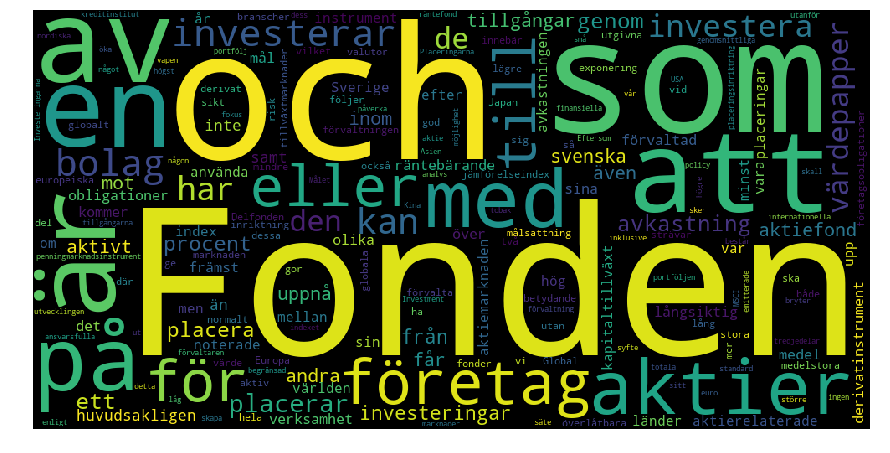

In [48]:
wordcloud = WordCloud(collocations=False,width = 1000, height = 500).generate(' '.join(fund_df['info']))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Most of the preprocessing we will be doing can be condensed into the function written below. We first split apart (i.e. tokenize) the 'info' string into a list of words, symbols, and punctuations. Then we remove allof the swedish stopwords. In english stopwords are words such as 'is', 'a', 'the', which are commonplace, but have little predictive value. 

#### After that we remove any tokens of length 1, which includes punctuation marks. The last step is to onlykeep the 'stem' of a word. For instance the stem of 'called' and 'cars' is 'call' and 'car'.

In [49]:
def fund_cleaner(df):
    for fund in list(df.index):
        info=df.loc[fund,'info']
        info=nltk.word_tokenize(info,'swedish')
        info=[word for word in info if word not in stopwords.words('swedish')]
        info=[word for word in info if len(word)>1]
        info=[SwedishStemmer().stem(word) for word in info]
        info=' '.join(info)
        df.loc[fund,'info']=info
    return df

#### Let's look at an example of the fund info before and after cleaning things up. Notice the length is reduced by around 1/3.

In [50]:
fund_df.loc['Amundi Fds SBI FM Eqty India Select AU-C','info']

'Delfondens mål är att söka långsiktig kapitaltillväxt genom att investera minst två 67 % av sina tillgångar i aktier i indiska företag. Delfonden kan investera i finansiella derivatinstrument för säkring och för effektiv förvaltning av portföljer. BSE 100 indexet utgör Delfondens referensindikator. Delfonden syftar inte till att replikera referensindikatorn och kan därför väsentligt avvika från den.'

In [51]:
_=fund_cleaner(fund_df)
fund_df.loc['Amundi Fds SBI FM Eqty India Select AU-C','info']

'delfond mål sök långsikt kapitaltillväxt genom invester minst två 67 tillgång akti indisk företag delfond invester finansiell derivatinstrument säkring effektiv förvaltning portfölj bse 100 indexet utgör delfond referensindikat delfond syft repliker referensindikatorn därför väsent avvik'

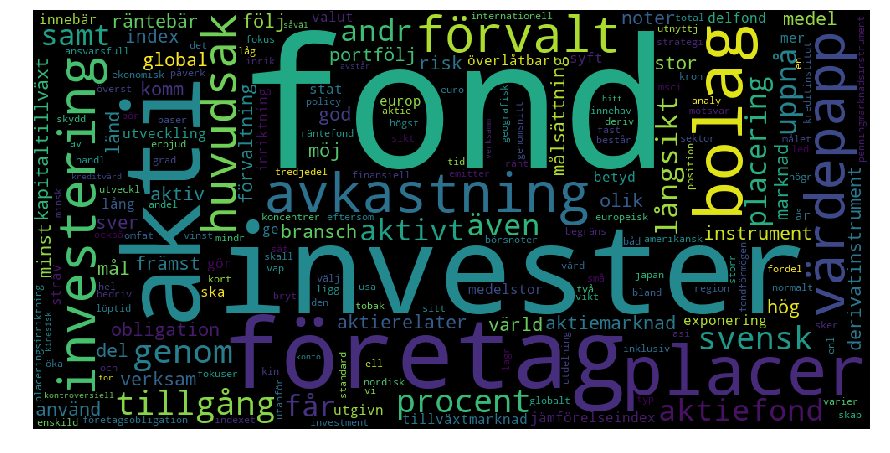

In [52]:
wordcloud = WordCloud(collocations=False,width = 1000, height = 500).generate(' '.join(fund_df['info']))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

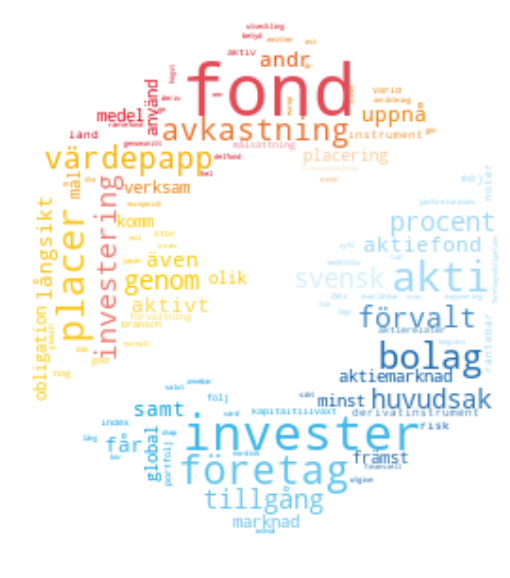

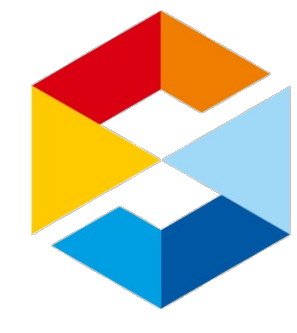

In [139]:
sbic_mask = np.array(Image.open( "SBIC.png"))

wordcloud = WordCloud(collocations=False,width = 1000, height = 500,mask=sbic_mask,background_color="white")
wordcloud.generate(' '.join(fund_df['info']))
image_colors = ImageColorGenerator(sbic_mask)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.figure()
plt.imshow(sbic_mask, cmap=plt.cm.gray, interpolation="bilinear")
plt.axis("off")
plt.show()

#### First we apply an unsupervised methods to group funds based on 'info'. The process consists of the following steps:

#### 1) For each fund 'info' and for each unique word in 'info',  count the number of times the word occurs in the fund 'info' and divide this by the number of times the word occurs in all funds 'info'. This is known as Term Frequency Inverse Document Frequency (i.e. tfidf ), and the output is a large sparse matrix where each row corresponds to a particular fund's 'info'.

#### 2) Apply a truncated Singular Value Decomposition (i.e. svd ), which attempts to compress the less usefule information in the matrix. 

#### This process more commonly goes by thename Latent Semantic Analysis or LDA.

In [9]:
svd_model=TruncatedSVD(n_components=500,algorithm='arpack')

transformer = TfidfVectorizer()

svd_transformer = Pipeline([('tfidf', transformer), 
                            ('svd', svd_model)])

svd_matrix = svd_transformer.fit_transform(fund_df['info'].values)

#### Now that each fund has been transformed into a vector in a high-dimensional space, let's see what fund's are similar to a given fund by comparing the fund vectors. In particular, we use the cosine distance to give the angle between vectors. If the two vectors are the same, then the angle will be zero.

In [10]:
def k_similar_funds(fund,k,fund_df):
    query_fund = svd_transformer.transform([fund_df.loc[fund,'info']])
    distance_matrix = pairwise_distances(query_fund, 
                                     svd_matrix, 
                                     metric='cosine', 
                                     n_jobs=-1)
    indices=distance_matrix[0,:].argsort()[:k+1]
    for i in indices:
        print('Fund Name: '+fund_df.index[i])
        print('Fund Category: '+fund_df['category'].iloc[i])
        print('')

In [11]:
k_similar_funds('AMF Aktiefond Sverige',5,fund_df)

Fund Name: AMF Aktiefond Sverige
Fund Category: Sverige

Fund Name: Monyx Svenska Aktier
Fund Category: Sverige

Fund Name: AMF Aktiefond Europa
Fund Category: Europa

Fund Name: SEB Världenfond
Fund Category: Blandfonder

Fund Name: SEB Nordic Focus C SEK
Fund Category: Norden

Fund Name: SEB Trygg Placeringsfond
Fund Category: Blandfonder



##### Above we see the five 'closest' funds to the fund AMF Aktiefond Sverige. Comparing this to the fund categories seems to show only a minor correlation between the fund's 'info' and the fund's category.

#### However, if we look at the geographical distribution of a couple of those funds we see a heavy investment presence in Sweden (i.e. Sverige), which is somewhat encouraging.

In [12]:
print('Geographical Distribution of SEB Nordic Focus C SEK investments: {}'.format(fund_df.loc['SEB Nordic Focus C SEK','regions']))
print('-----------------------------------------------------------------------------------------------------------')
print('Geographical Distribution of SEB Trygg Placeringsfond investments: {}'.format(fund_df.loc['SEB Trygg Placeringsfond','regions']))

Geographical Distribution of SEB Nordic Focus C SEK investments: {'Västeuropa exkl Sverige': '52.4', 'Nordamerika': '3.7', 'Sverige': '43.9'}
-----------------------------------------------------------------------------------------------------------
Geographical Distribution of SEB Trygg Placeringsfond investments: {'Västeuropa exkl Sverige': '13.4', 'Östeuropa': '3.7', 'Sverige': '36.9', 'Asien exkl Japan': '5.1', 'Nordamerika': '33.2', 'Afrika och Mellanöstern': '0.2', 'Australien och Nya Zeeland': '0.7', 'Japan': '6.9', 'Latinamerika': '0.0'}


#### Below we see that there are 37 distinct fund categories, and some of the categories have as few as 2 funds. This is a mutli-class dataset with significant class imbalance.

In [13]:
print('# of fund categories: {}'.format(len(fund_df.groupby('category').count().index)))
fund_df.loc[:,['info','category']].groupby('category').count()

# of fund categories: 37


,info
category,
-,21
Afrika och Mellanöstern,14
Asien,135
BRIC,4
Bioteknologi,6
Blandfonder,95
Brasilien,5
EURO,36
Energi,5


#### We now move on to supervised learning via classification, and we begin by splitting the dataset of funds into a traing set and a test set. We randomly split a quarter of the set into the test set, and do so by maintaing the ratio of classes/categories.

#### Given the combination of the imbalanced classes and the small populations of many of the fund classes, our expectations should not be too high. Additionally, there is a wide range in the length of each fund's text, which will bias our estimator towards longer texts.

In [72]:
def data_split(df):
    test_funds=[]
    class_counts=df.loc[:,['info','category']].groupby('category').count()
    test_counts=class_counts['info'].apply(lambda x: int(0.25*x))
    for index, count in test_counts.iteritems():
        indices=random.sample(range(0,class_counts.loc[index][0]),count)
        test_funds+=list(df.loc[fund_df['category']==index].index[indices])
    return test_funds

In [73]:
test_index=data_split(fund_df)
test_set=fund_df.loc[test_index,:]
train_set=fund_df.loc[~fund_df.index.isin(test_index)]

In [74]:
X_test=test_set['info'].values
y_test=test_set['category'].values
X_train=train_set['info'].values
y_train=train_set['category'].values

  Actual number of tfidf features: 3516
Some random words in the vocabulary:
  sub
  generer
  hemvist
  företräd
  skräddarsy
  idé
  selekteringssystem
  dock
  beloppet
  uppnå
(800, 3516)
(800,)


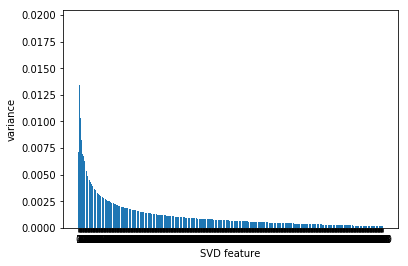

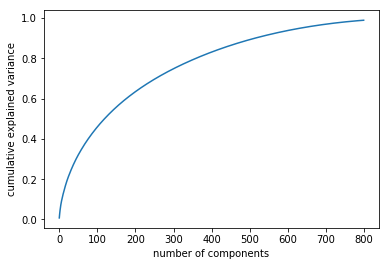

In [122]:
svd=TruncatedSVD(n_components=800)
vectorizer=TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("  Actual number of tfidf features: %d" % X_train_tfidf.get_shape()[1])

feat_names = vectorizer.get_feature_names()

print("Some random words in the vocabulary:")
for i in range(0, 10):
    featNum = random.randint(0, len(feat_names))
    print("  %s" % feat_names[featNum])
    
X_train_lsa = svd.fit_transform(X_train_tfidf)
X_test_lsa = svd.transform(X_test_tfidf)

print(svd.components_.shape)
print(svd.explained_variance_.shape)
features = range(svd.components_.shape[0])
plt.bar(features, svd.explained_variance_)
plt.xlabel('SVD feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

#### We need a couple of functions for running a Naive Bayes classifier based on a multinomial distribution and a function to show how each category fared.

#### A Naive Bayes classifier makes a naive assumption that the features (i.e. word frequencies) are statistically independent. For some words this may be true, but for many this is not true at all (i.e. 'mutual' and 'fund'). Later we can use n-grams (multiple words) as features to help this situation.

In [116]:
def score_counts(y_test,y_predic):
    correct_counts=defaultdict(int)
    counts=defaultdict(int)
    i=0
    for fund_class in y_test:
        counts[fund_class]+=1
        if fund_class==y_predic[i]:
            correct_counts[fund_class]+=1
        i+=1
    
    if printing==True:
        print("Accuracy: {}".format(sum(correct_counts.values())/sum(counts.values())))
        for key, value in counts.items():
            print(key+": {}".format(correct_counts[key])+'/{}'.format(value))
        
    return (correct_counts,counts)

In [129]:
def NB_classify_and_score(X_train,y_train,X_test,y_test):
    steps = [('tfid', TfidfVectorizer()),
             ('NB', MultinomialNB())]

    pipeline = Pipeline(steps)

    pipeline.fit(X_train,y_train)
    
    y_predic = pipeline.predict(X_test)
    
    score_counts(y_test,y_predic)
    
    return pipeline.score(X_test,y_test)

In [128]:
def MNB_classify_and_score(X_train,y_train,X_test,y_test):
    steps = [('count', CountVectorizer()),
             ('NB', MultinomialNB())]

    pipeline = Pipeline(steps)

    pipeline.fit(X_train,y_train)
    
    y_predic = pipeline.predict(X_test)
    
    score_counts(y_test,y_predic)
    
    return pipeline.score(X_test,y_test)

In [127]:
def NB_CV_classify_and_score(X_train,y_train,X_test,y_test):
    steps = [('tfid', TfidfVectorizer()),
             ('NB', MultinomialNB())]
    
    param_grid={'tfid__ngram_range':[(1,1),(1,2),(2,2),(1,3),(2,3)],
                'NB__alpha':[0.2,0.5,1]}
    
    pipeline = Pipeline(steps)

    nb_cv=GridSearchCV(pipeline,param_grid,cv=5)

    nb_cv.fit(X_train,y_train)
    
    y_predic = nb_cv.predict(X_test)
    
    print("Tuned Parameter: {}".format(nb_cv.best_params_))
    
    score_counts(y_test,y_predic)
    
    return nb_cv.score(X_test,y_test)

In [126]:
def KNN_classify_and_score(X_train,y_train,X_test,y_test):
    steps = [('tfid', TfidfVectorizer()),
             ('knn', KNeighborsClassifier(n_jobs=-1))]
    
    neighbors=np.arange(2,9)
    param_grid={'tfid__ngram_range':[(1,1),(1,2),(2,2)],
                'knn__n_neighbors':neighbors,
                'knn__metric':['minkowski','cosine']}
    
    pipeline = Pipeline(steps)

    knn_cv=GridSearchCV(pipeline,param_grid,cv=5)

    knn_cv.fit(X_train,y_train)
    
    y_predic = knn_cv.predict(X_test)
    
    print("Tuned Parameter: {}".format(knn_cv.best_params_))
    
    score_counts(y_test,y_predic)
    
    return knn_cv.score(X_test,y_test)

In [142]:
def SVC_classify_and_score(X_train,y_train,X_test,y_test):
    steps = [('tfid', TfidfVectorizer()),
             ('svc', SGDClassifier(n_jobs=-1))]
    
    neighbors=np.arange(2,9)
    param_grid={'tfid__ngram_range':[(1,1),(1,2),(2,2)],
                'svc__penalty':['l1','l2','elasticnet']}
    
    pipeline = Pipeline(steps)

    svc_cv=GridSearchCV(pipeline,param_grid,cv=5)

    svc_cv.fit(X_train,y_train)
    
    y_predic = svc_cv.predict(X_test)
    
    print("Tuned Parameter: {}".format(svc_cv.best_params_))
    
    score_counts(y_test,y_predic)
    
    return svc_cv.score(X_test,y_test)

In [146]:
def LR_classify_and_score(X_train,y_train,X_test,y_test):
    steps = [('tfid', TfidfVectorizer()),
             ('lr', SGDClassifier(n_jobs=-1,loss='log'))]
    
    neighbors=np.arange(2,9)
    param_grid={'tfid__ngram_range':[(1,1),(1,2),(2,2)],
                'lr__penalty':['l1','l2','elasticnet']}
    
    pipeline = Pipeline(steps)

    lr_cv=GridSearchCV(pipeline,param_grid,cv=5)

    lr_cv.fit(X_train,y_train)
    
    y_predic = lr_cv.predict(X_test)
    
    print("Tuned Parameter: {}".format(lr_cv.best_params_))
    
    score_counts(y_test,y_predic)
    
    return lr_cv.score(X_test,y_test)

#### Below we see that only around 48% of the funds in the test set were correctly classified. This is not very encouraging, but it is far better than the around 3% accuracy a truely random approach would yield.

#### Unsurprisingly, the under represented fund categories performed the worst.

In [145]:
printing=False

scores={'MNB_tfifd':NB_classify_and_score(X_train,y_train,X_test,y_test),'MNB':MNB_classify_and_score(X_train,y_train,X_test,y_test),
        'MNB_tfifd_reg':NB_CV_classify_and_score(X_train,y_train,X_test,y_test), 'KNN_tfifd':KNN_classify_and_score(X_train,y_train,X_test,y_test),
        'SVC_tfifd_reg':SVC_classify_and_score(X_train,y_train,X_test,y_test),'LogReg_tfidf_reg':LR_classify_and_score(X_train,y_train,X_test,y_test)}

Tuned Parameter: {'NB__alpha': 0.2, 'tfid__ngram_range': (1, 1)}
Tuned Parameter: {'knn__metric': 'minkowski', 'knn__n_neighbors': 8, 'tfid__ngram_range': (1, 1)}
Tuned Parameter: {'svc__loss': 'log', 'tfid__ngram_range': (1, 1), 'svc__penalty': 'l1'}
Tuned Parameter: {'lr__penalty': 'l1', 'tfid__ngram_range': (1, 1)}


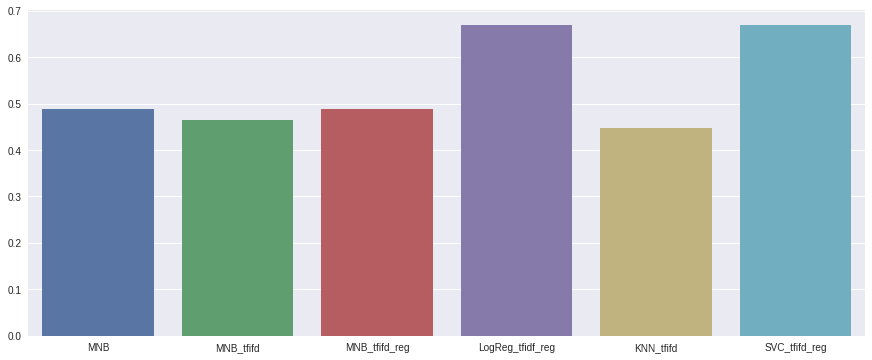

In [147]:
sns.set()
plt.figure(figsize=(15, 6))
sns.barplot(x=[name for name, _ in scores.items()], y=[score for _, score in scores.items()])
plt.show()

printing=True

In [148]:
scores

{'KNN_tfifd': 0.44794952681388012,
 'LogReg_tfidf_reg': 0.66876971608832803,
 'MNB': 0.48895899053627762,
 'MNB_tfifd': 0.4637223974763407,
 'MNB_tfifd_reg': 0.48895899053627762,
 'SVC_tfifd_reg': 0.66876971608832803}

In [93]:
NB_classify_and_score(X_train,y_train,X_test,y_test)

Accuracy: 0.4637223974763407
Energi: 0/1
Ädelmetaller: 0/1
USD: 0/2
EURO: 0/9
Turkiet: 0/1
Asien: 30/33
Japan: 0/8
Afrika och Mellanöstern: 0/3
Infrastruktur: 0/1
Ryssland: 0/4
Ny Energi: 0/1
Östeuropa: 0/5
Sverige: 20/26
Läkemedel: 0/3
Konvertibler: 0/1
Miljö: 0/1
Ny Teknologi: 0/5
Tillväxtmarknader: 1/18
Global: 19/31
Finans: 0/1
Övriga: 17/25
BRIC: 0/1
Konsument: 0/2
Blandfonder: 14/23
Europa: 16/28
-: 0/5
Brasilien: 0/1
Latinamerika: 0/3
Fastigheter: 0/6
Norden: 0/9
SEK: 17/19
Råvaror: 0/3
Hedgefonder: 12/21
Bioteknologi: 0/1
Nordamerika: 1/15


In [97]:
NB_CV_classify_and_score(X_train,y_train,X_test,y_test)

Tuned Parameter: {'NB__alpha': 0.2, 'tfid__ngram_range': (1, 1)}
Accuracy: 0.4889589905362776
Energi: 0/1
Ädelmetaller: 0/1
USD: 0/2
EURO: 0/9
Turkiet: 0/1
Asien: 29/33
Japan: 3/8
Afrika och Mellanöstern: 0/3
Infrastruktur: 0/1
Ryssland: 0/4
Ny Energi: 0/1
Östeuropa: 1/5
Sverige: 19/26
Läkemedel: 0/3
Konvertibler: 0/1
Miljö: 0/1
Ny Teknologi: 0/5
Tillväxtmarknader: 4/18
Global: 14/31
Finans: 0/1
Övriga: 15/25
BRIC: 0/1
Konsument: 0/2
Blandfonder: 17/23
Europa: 16/28
-: 0/5
Brasilien: 0/1
Latinamerika: 0/3
Fastigheter: 0/6
Norden: 0/9
SEK: 17/19
Råvaror: 0/3
Hedgefonder: 16/21
Bioteknologi: 0/1
Nordamerika: 4/15


In [106]:
MNB_classify_and_score(X_train,y_train,X_test,y_test)

Accuracy: 0.4889589905362776
Energi: 0/1
Ädelmetaller: 0/1
USD: 0/2
EURO: 0/9
Turkiet: 0/1
Asien: 28/33
Japan: 0/8
Afrika och Mellanöstern: 0/3
Infrastruktur: 0/1
Ryssland: 0/4
Ny Energi: 0/1
Östeuropa: 1/5
Sverige: 22/26
Läkemedel: 0/3
Konvertibler: 0/1
Miljö: 0/1
Ny Teknologi: 0/5
Tillväxtmarknader: 3/18
Global: 17/31
Finans: 0/1
Övriga: 18/25
BRIC: 0/1
Konsument: 0/2
Blandfonder: 19/23
Europa: 13/28
-: 0/5
Brasilien: 0/1
Latinamerika: 0/3
Fastigheter: 0/6
Norden: 1/9
SEK: 17/19
Råvaror: 0/3
Hedgefonder: 13/21
Bioteknologi: 0/1
Nordamerika: 3/15


In [95]:
KNN_classify_and_score(X_train,y_train,X_test,y_test)

Tuned Parameter: {'knn__metric': 'minkowski', 'knn__n_neighbors': 8, 'tfid__ngram_range': (1, 1)}
Accuracy: 0.4479495268138801
Energi: 0/1
Ädelmetaller: 0/1
USD: 1/2
EURO: 2/9
Turkiet: 0/1
Asien: 26/33
Japan: 3/8
Afrika och Mellanöstern: 2/3
Infrastruktur: 0/1
Ryssland: 1/4
Ny Energi: 0/1
Östeuropa: 1/5
Sverige: 15/26
Läkemedel: 1/3
Konvertibler: 0/1
Miljö: 0/1
Ny Teknologi: 0/5
Tillväxtmarknader: 2/18
Global: 12/31
Finans: 0/1
Övriga: 8/25
BRIC: 0/1
Konsument: 0/2
Blandfonder: 10/23
Europa: 11/28
-: 1/5
Brasilien: 0/1
Latinamerika: 1/3
Fastigheter: 4/6
Norden: 6/9
SEK: 14/19
Råvaror: 1/3
Hedgefonder: 10/21
Bioteknologi: 1/1
Nordamerika: 9/15


In [154]:
SVC_classify_and_score(X_train,y_train,X_test,y_test)

Tuned Parameter: {'svc__loss': 'log', 'tfid__ngram_range': (1, 1), 'svc__penalty': 'l1'}
Accuracy: 0.6719242902208202
Energi: 0/1
Ädelmetaller: 0/1
USD: 0/2
EURO: 3/9
Turkiet: 0/1
Asien: 28/33
Japan: 7/8
Afrika och Mellanöstern: 1/3
Infrastruktur: 1/1
Ryssland: 2/4
Ny Energi: 0/1
Östeuropa: 3/5
Sverige: 23/26
Läkemedel: 1/3
Konvertibler: 0/1
Miljö: 0/1
Ny Teknologi: 1/5
Tillväxtmarknader: 12/18
Global: 20/31
Finans: 0/1
Övriga: 15/25
BRIC: 0/1
Konsument: 0/2
Blandfonder: 18/23
Europa: 23/28
-: 0/5
Brasilien: 1/1
Latinamerika: 2/3
Fastigheter: 3/6
Norden: 5/9
SEK: 18/19
Råvaror: 0/3
Hedgefonder: 13/21
Bioteknologi: 1/1
Nordamerika: 12/15


0.67192429022082023

In [155]:
LR_classify_and_score(X_train,y_train,X_test,y_test)

Tuned Parameter: {'lr__penalty': 'l1', 'tfid__ngram_range': (1, 1)}
Accuracy: 0.6656151419558359
Energi: 0/1
Ädelmetaller: 0/1
USD: 0/2
EURO: 3/9
Turkiet: 0/1
Asien: 29/33
Japan: 7/8
Afrika och Mellanöstern: 1/3
Infrastruktur: 1/1
Ryssland: 2/4
Ny Energi: 0/1
Östeuropa: 3/5
Sverige: 24/26
Läkemedel: 1/3
Konvertibler: 0/1
Miljö: 0/1
Ny Teknologi: 0/5
Tillväxtmarknader: 11/18
Global: 22/31
Finans: 0/1
Övriga: 14/25
BRIC: 0/1
Konsument: 0/2
Blandfonder: 17/23
Europa: 22/28
-: 0/5
Brasilien: 1/1
Latinamerika: 2/3
Fastigheter: 3/6
Norden: 4/9
SEK: 18/19
Råvaror: 0/3
Hedgefonder: 13/21
Bioteknologi: 1/1
Nordamerika: 12/15


0.66561514195583593

#### Let's run it again, but this time using only the top 5 most populated fund categories.

In [98]:
top_classes=list(fund_df.loc[:,['info','category']].groupby('category').count().sort_values('info',ascending=False).head(5).index)
print(top_classes)

['Asien', 'Global', 'Europa', 'Sverige', 'Övriga']


In [99]:
X_test_sub=test_set.loc[test_set['category'].isin(top_classes)]['info'].values
y_test_sub=test_set.loc[test_set['category'].isin(top_classes)]['category'].values
X_train_sub=train_set.loc[train_set['category'].isin(top_classes)]['info'].values
y_train_sub=train_set.loc[train_set['category'].isin(top_classes)]['category'].values

#### Our accuracy has almost doubled to 81%, which is a nice improvement. We could either gather more dataon the under represented categories, or we could consider consolidating some of the fund categories to get better performance outof our classifier. Of course, we have only tried a fairly basic classifier, so there are many more methods we can consider. 

In [100]:
NB_classify_and_score(X_train_sub,y_train_sub,X_test_sub,y_test_sub)

Accuracy: 0.7622377622377622
Asien: 29/33
Global: 22/31
Sverige: 21/26
Europa: 15/28
Övriga: 22/25


In [101]:
NB_CV_classify_and_score(X_train_sub,y_train_sub,X_test_sub,y_test_sub)

Tuned Parameter: {'NB__alpha': 0.5, 'tfid__ngram_range': (1, 1)}
Accuracy: 0.7552447552447552
Asien: 28/33
Global: 20/31
Sverige: 22/26
Europa: 17/28
Övriga: 21/25


In [107]:
MNB_classify_and_score(X_train_sub,y_train_sub,X_test_sub,y_test_sub)

Accuracy: 0.7622377622377622
Asien: 27/33
Global: 20/31
Sverige: 23/26
Europa: 15/28
Övriga: 24/25


In [108]:
KNN_classify_and_score(X_train_sub,y_train_sub,X_test_sub,y_test_sub)

Tuned Parameter: {'knn__metric': 'minkowski', 'knn__n_neighbors': 7, 'tfid__ngram_range': (1, 1)}
Accuracy: 0.6503496503496503
Asien: 27/33
Global: 12/31
Sverige: 20/26
Europa: 16/28
Övriga: 18/25


In [149]:
SVC_classify_and_score(X_train_sub,y_train_sub,X_test_sub,y_test_sub)

Tuned Parameter: {'svc__loss': 'log', 'tfid__ngram_range': (1, 2), 'svc__penalty': 'l1'}
Accuracy: 0.9020979020979021
Asien: 29/33
Global: 28/31
Sverige: 25/26
Europa: 24/28
Övriga: 23/25


0.90209790209790208

In [150]:
LR_classify_and_score(X_train_sub,y_train_sub,X_test_sub,y_test_sub)

Tuned Parameter: {'lr__penalty': 'l1', 'tfid__ngram_range': (1, 2)}
Accuracy: 0.8881118881118881
Asien: 30/33
Global: 25/31
Sverige: 25/26
Europa: 25/28
Övriga: 22/25


0.88811188811188813

#### Before we move on to other methods let's look at 'fund_type' as opposed to fund 'category'. There are only 7 fund types as opposed to 37 fund categories. However, class imbalance is still an issue, since the 'Aktiefond' type is heavily represented in the dataset.

In [157]:
print('# of fund types: {}'.format(len(fund_df.groupby('fund_type').count().index)))
fund_df.loc[:,['info','fund_type']].groupby('fund_type').count()

# of fund types: 7


,info
fund_type,
-,21
Aktiefond,763
Blandfond,95
Branschfond,126
Hedgefond,87
Räntefond,224
Övrigt,4


In [158]:
def data_split(df,column):
    test_funds=[]
    class_counts=df.loc[:,['info',column]].groupby(column).count()
    test_counts=class_counts['info'].apply(lambda x: int(0.25*x))
    for index, count in test_counts.iteritems():
        indices=random.sample(range(0,class_counts.loc[index][0]),count)
        test_funds+=list(df.loc[fund_df[column]==index].index[indices])
    
    return test_funds

In [159]:
test_index=data_split(fund_df,'fund_type')
test_set=fund_df.loc[test_index,:]
train_set=fund_df.loc[~fund_df.index.isin(test_index)]

In [162]:
X_test=test_set['info'].values
y_test=test_set['fund_type'].values
X_train=train_set['info'].values
y_train=train_set['fund_type'].values

In [163]:
NB_classify_and_score(X_train,y_train,X_test,y_test)

Accuracy: 0.6605504587155964
Branschfond: 0/31
Blandfond: 0/23
Hedgefond: 0/21
Övrigt: 0/1
Aktiefond: 190/190
-: 0/5
Räntefond: 26/56


0.66055045871559637

In [164]:
SVC_classify_and_score(X_train,y_train,X_test,y_test)

Tuned Parameter: {'svc__loss': 'log', 'tfid__ngram_range': (1, 1), 'svc__penalty': 'l1'}
Accuracy: 0.8409785932721713
Branschfond: 14/31
Blandfond: 13/23
Hedgefond: 11/21
Övrigt: 0/1
Aktiefond: 184/190
-: 0/5
Räntefond: 53/56


0.84097859327217128

#### Over 67% of the funds in the test set are correctly given the fund type by the Naive Bayes classifier. This isn't too bad, but we should be able to do better by bringing in other features and methods.

#### Let's consider the traditional Multinomial Naive Bayes model for text classification given by:

$$P(c\vert d) = \frac{P(c) \Pi_{w \in d} P(w \vert c)^{n_{w,d}}}{P(d)}, \qquad \text{and} \qquad P(w \vert c) = \frac{1+\sum_{d \in D_c} n_{w,d}}{k+\sum_{w'}\sum_{d \in D_c}n_{w',d}}$$

#### where $P(c)$ is calculated from the class, $c$, frequency in the dataset, $P(d)$ is chosen to make the first quantity a probability(i.e sum to 1), $d$ is a given document, $w$, $w'$ are words in the dataset or document, $n_{w,d}$ is the frequency of word, $w$, in document, $d$, and $D_c$ is the set of documents in class $c$ from the dataset.

#### The 1 and $k$ added in the numerator and denominator, respectively, of the second equation are known as the Laplace correction, and the idea is to have a small, but nonzero probability for a word appearing in a particular class even if it does not happen in the training set.

#### For imbalanced text classfication there are some adjustments that can be made to Tf-idf and Multinomial Naive Bayes that lead to better performance. The following functions perform the adjustments outlined in this paper:
https://people.csail.mit.edu/jrennie/papers/icml03-nb.pdf

#### Primarily, we are applying a log-transform to the word counts, so that they adhere less to a power-law distribution and more to a multinomial distribution. Then we normalize the resulting document vectors, so that larger documents are not weighted more than smaller documents. Next a modified form of Naive Bayes known as Weighted Complement Naive Bayes is applied, which calculates the probability for each class by looking at the complement probability given by grouping the remaining class into one class, and then normalize this value.

In [280]:
def word_class_weights(df):
    info_dict={}
    for fund in df.index:
        fund_count=Counter(df.loc[fund,'info'].split(' '))
        info_dict[fund]=fund_count
    categories=df['category'].unique()
    word_df=pd.DataFrame.from_dict(info_dict,orient='index')
    word_df.fillna(0,inplace=True)
    word_df=word_df.apply(lambda x: np.log(x+1))
    n=len(word_df.index)
    m=len(word_df.columns)
    column_sums=word_df.apply(lambda x: x!=0).sum(0)
    for column in word_df:
        word_df[column]=word_df[column].apply(lambda x: x*np.log(n/column_sums[column]))
    row_norms=((word_df**2).sum(1))**0.5
    word_df=word_df.div(row_norms,axis=0)
    word_df=word_df.join(df['category'])
    weight_dict={}
    for category in categories:
        weight_dict[category]=((word_df.groupby('category').sum(axis=0).drop(category).sum(axis=0)+1)/(word_df.groupby('category').sum(axis=0).drop(category).sum(axis=0).sum()+m)).apply(np.log)
        weight_dict[category]=weight_dict[category]/(weight_dict[category].sum())
    word_df=pd.DataFrame.from_dict(weight_dict,orient='index')
    return word_df

In [9]:
def word_counts(df):
    info_dict={}
    for fund in df.index:
        fund_count=Counter(df.loc[fund,'info'].split(' '))
        info_dict[fund]=fund_count
    word_df=pd.DataFrame.from_dict(info_dict,orient='index')
    word_df.fillna(0,inplace=True)
    word_df=word_df.join(df['category'])
    return word_df

In [328]:
def TWCNB(train_df,test_df):
    weights=word_class_weights(train_df)
    counts=word_counts(test_df)
    y_test=list(counts.category)
    y_predicted=[]
    for index, row in counts.iloc[:,:-1].iterrows():
        y_predicted.append(weights.multiply(row).sum(1).idxmax())
    score_counts(y_test, y_predicted)
    return y_predicted

In [309]:
y_predicted=TWCNB(train_set,test_set)

Accuracy: 0.5772870662460567
Asien: 30/61
Global: 19/37
Nordamerika: 11/13
Blandfonder: 17/24
Ny Energi: 1/1
EURO: 1/3
Japan: 3/3
Latinamerika: 1/1
Ryssland: 1/1
Hedgefonder: 15/17
Övriga: 14/21
Tillväxtmarknader: 7/17
Norden: 1/1
Läkemedel: 1/1
SEK: 19/27
Bioteknologi: 1/1
Europa: 19/34
Sverige: 21/53
Östeuropa: 1/1


#### The adjustments boosted accuracy from 46% to 58%, so it definitely helped

In [172]:
train_no_cat=fund_df.loc[fund_df.category!='-'].loc[:,['info','category']]
test_no_cat=fund_df.loc[fund_df.category=='-'].loc[:,['info','category']]

In [174]:
X_train_no_cat=train_no_cat['info'].values
y_train_no_cat=train_no_cat['category'].values
X_test_no_cat=test_no_cat['info'].values

In [183]:
def SVC_classify(X_train,y_train,X_test):
    steps = [('tfid', TfidfVectorizer()),
             ('svc', SGDClassifier(n_jobs=-1))]
    
    neighbors=np.arange(2,9)
    param_grid={'tfid__ngram_range':[(1,1),(1,2),(2,2)],
                'svc__penalty':['l1','l2','elasticnet']}
    
    pipeline = Pipeline(steps)

    svc_cv=GridSearchCV(pipeline,param_grid,cv=5)

    svc_cv.fit(X_train,y_train)
    
    y_predic = svc_cv.predict(X_test)
    
    print("Tuned Parameter: {}".format(svc_cv.best_params_))
    print("CV_Tuned_Accuracy: {}".format(svc_cv.best_score_))
    
    return y_predic

In [184]:
y_predicted=SVC_classify(X_train_no_cat,y_train_no_cat,X_test_no_cat)

Tuned Parameter: {'tfid__ngram_range': (1, 2), 'svc__penalty': 'l1'}
CV_Tuned_Accuracy: 0.642802155504234


In [186]:
i=0
for fund in test_no_cat.index:
    print("Fund : "+fund)
    print("Predicted Category: "+y_predicted[i])
    print("Fund Type: "+dict_of_funds[fund]['fund_type'])
    print("Holdings: {}".format(dict_of_funds[fund]['holdings']))
    print("Regions: {}".format(dict_of_funds[fund]['regions']))
    print("Sectors: {}".format(dict_of_funds[fund]['industries']))
    i+=1
    print("------------------------------------------------------------------------------------------------------")

Fund : Aberdeen Global European Eq Div S2 EUR
Predicted Category: Europa
Fund Type: -
Holdings: {'Roche Holding AG Dividend Right Cert.': '3.1', 'Nestle SA': '3.4', 'Unilever PLC': '3.8', 'Nordea Bank AB': '4.0', 'Novo Nordisk A/S B': '3.6', 'British American Tobacco PLC': '3.6', 'UBS Group AG': '3.4', 'Övrigt': '68.2', 'Royal Dutch Shell PLC B': '3.2', 'Prudential PLC': '3.8'}
Regions: {'Sverige': '7.9', 'Västeuropa exkl Sverige': '92.1'}
Sectors: {'Energi': '6.6', 'Fastigheter': '2.9', 'Finans': '24.5', 'Sjukvård': '13.8', 'Konsument, stabil': '17.9', 'Övrigt': '3.1', 'Industri': '13.7', 'Kommunikation': '5.1', 'Råvaror': '4.8', 'Konsument, cyklisk': '7.5'}
------------------------------------------------------------------------------------------------------
Fund : Alfred Berg Bear
Predicted Category: Sverige
Fund Type: -
Holdings: {'Omxs30 Fut 0817': '4.6', 'Sweden(Kingdom Of) 3.75%': '14.7', 'Swedish T-Bill 201d 0pct 200917': '14.2', 'Sweden(Kingdom Of)': '9.4', 'Sweden(Kingdom Of)

In [188]:
train_no_type=fund_df.loc[fund_df.fund_type!='-'].loc[:,['info','fund_type']]
test_no_type=fund_df.loc[fund_df.fund_type=='-'].loc[:,['info','fund_type']]

In [190]:
X_train_no_type=train_no_type['info'].values
y_train_no_type=train_no_type['fund_type'].values
X_test_no_type=test_no_type['info'].values
y_predicted=SVC_classify(X_train_no_type,y_train_no_type,X_test_no_type)

Tuned Parameter: {'tfid__ngram_range': (1, 2), 'svc__penalty': 'l1'}
CV_Tuned_Accuracy: 0.8290993071593533


In [191]:
i=0
for fund in test_no_type.index:
    print("Fund : "+fund)
    print("Predicted Fund Type: "+y_predicted[i])
    print("Fund Category: "+dict_of_funds[fund]['category'])
    print("Holdings: {}".format(dict_of_funds[fund]['holdings']))
    print("Regions: {}".format(dict_of_funds[fund]['regions']))
    print("Sectors: {}".format(dict_of_funds[fund]['industries']))
    i+=1
    print("------------------------------------------------------------------------------------------------------")

Fund : Aberdeen Global European Eq Div S2 EUR
Predicted Fund Type: Aktiefond
Fund Category: -
Holdings: {'Roche Holding AG Dividend Right Cert.': '3.1', 'Nestle SA': '3.4', 'Unilever PLC': '3.8', 'Nordea Bank AB': '4.0', 'Novo Nordisk A/S B': '3.6', 'British American Tobacco PLC': '3.6', 'UBS Group AG': '3.4', 'Övrigt': '68.2', 'Royal Dutch Shell PLC B': '3.2', 'Prudential PLC': '3.8'}
Regions: {'Sverige': '7.9', 'Västeuropa exkl Sverige': '92.1'}
Sectors: {'Energi': '6.6', 'Fastigheter': '2.9', 'Finans': '24.5', 'Sjukvård': '13.8', 'Konsument, stabil': '17.9', 'Övrigt': '3.1', 'Industri': '13.7', 'Kommunikation': '5.1', 'Råvaror': '4.8', 'Konsument, cyklisk': '7.5'}
------------------------------------------------------------------------------------------------------
Fund : Alfred Berg Bear
Predicted Fund Type: Aktiefond
Fund Category: -
Holdings: {'Omxs30 Fut 0817': '4.6', 'Sweden(Kingdom Of) 3.75%': '14.7', 'Swedish T-Bill 201d 0pct 200917': '14.2', 'Sweden(Kingdom Of)': '9.4', 'Swe

In [192]:
fund

'Sparinvest SICAV Long Danish Bds EUR R'

In [204]:
regions=[]
sectors=[]
for fund, fund_dict in dict_of_funds.items():
    for region, percent in fund_dict['regions'].items():
        regions.append(region)
        if type(percent)==type('') and len(percent)<=5:
            fund_dict['regions'][region]=float(percent)
    for sector, percent in fund_dict['industries'].items():
        sectors.append(sector)
        if type(percent)==type('') and len(percent)<=5:
            fund_dict['industries'][sector]=float(percent)
regions=list(set(regions))
sectors=list(set(sectors))
print(regions)
print(sectors)

KeyError: 'regions'

In [210]:
dict_of_funds[fund]['link']

'https://www.avanza.se/fonder/om-fonden.html/73515/fidelity-european-hi-yld-a-acc-eur'